# EDA

## Imports

In [40]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')

import fastai
from fastai.vision.all import *
from fastai.vision.widgets import *

## Basic Reading & Statistics

In [5]:
# read csvs
train_df = pd.read_csv('dataset_FER/train.csv')
test_df = pd.read_csv('dataset_FER/test.csv')

In [6]:
train_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 1...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 154 153 164 173 178 185 185 189 187 186 193 194 185 183 186 180 173 166 161 147 133 172 151 114 161 161 146 131 104 95 132 163 123 119 129 140 120 151 149 149 153 137 115 129 166 170 181 164 143 157 156 169 179 185 183 186 186 184 190 191 184 186 190 183 175 168 160 147 136 135 167 136 108 153 167 149 137 111 90 134 162 121 122 141 137 151 151 156 143 116 124 159 164 174 169 135 144 155 153 164 170 176 178 177 178 187 185 181 182 183 181 178 170 164 158 148 144 130 136 173 130 97 137 167 157 138 113 90 138 168 109 123 146 151 152 155 127 113 159 ...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38 39 74 138 161 164 179 190 201 210 216 220 224 222 218 216 213 217 220 220 218 217 212 174 160 162 160 139 135 137 131 94 56 36 44 27 16 229 175 148 173 154 151 171 172 183 101 23 25 67 127 164 170 171 182 199 212 219 220 224 226 226 226 226 226 227 227 228 225 221 217 202 174 158 155 145 126 126 129 99 70 37 27 35 27 214 156 157 168 153 172 168 175 100 16 8 47 117 169 175 175 183 194 204 214 218 223 225 227 228 226 229 231 232 232 229 227 225 224 217 198 174 154 134 110 97 115 96 69 52 28 22 28 202 153 166 156 164 166 170 116 26 2 21 90 165 18...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 19 43 52 13 26 40 59 65 12 20 63 99 98 98 111 75 62 41 73 118 140 192 186 187 188 190 190 187 182 176 173 172 173 25 34 29 35 29 26 20 23 19 31 22 21 20 31 26 17 34 75 37 18 38 80 85 25 38 26 34 97 94 76 86 95 70 39 98 129 185 188 188 189 190 190 188 182 176 173 172 173 26 29 25 35 25 30 20 21 16 28 34 26 15 17 19 22 29 62 64 47 45 76 76 78 65 82 12 14 56 56 72 74 66 65 86 129 172 190 187 189 190 190 187 182 177 172 172 174 26 33 32 31 25 33 26 21 16 16 37 27 14 15 12 17 31 38 40 58 73 59 35 82 68 72 43 22 33 52 51 66 71 57 71 121 160 191 188 18...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84 115 127 137 142 151 156 155 149 153 152 157 160 162 159 145 121 83 58 48 38 21 17 7 5 25 27 24 25 1 0 0 0 0 0 0 0 0 0 0 6 18 26 37 50 62 83 115 134 138 144 147 150 162 163 164 161 165 169 171 176 175 177 169 147 110 79 64 42 23 13 9 2 16 26 23 26 0 0 0 0 0 0 0 0 0 1 6 18 29 49 73 93 116 129 138 143 148 153 158 158 162 168 170 169 170 176 181 185 186 183 180 167 143 109 81 54 29 11 8 3 10 27 26 26 0 0 0 0 0 0 0 0 0 8 32 55 74 94 108 121 127 132 138 145 154 159 160 162 166 170 174 173 177 181 183 183 186 188 188 180 164 138 113 69 36 14 4 3 11 2...


In [7]:
test_df.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 76 75 78 68 18 32 29 0 54 73 75 72 68 75 77 76 76 75 80 51 36 47 40 44 42 37 48 40 64 54 54 86 16 0 161 254 254 254 254 254 248 255 120 2 38 50 47 76 76 83 63 51 142 174 159 88 59 48 67 37 61 46 77 77 75 74 85 19 54 81 73 50 49 53 72 45 41 66 53 70 17 0 122 254 254 254 254 253 253 250 61 17 52 34 34 76 79 68 50 129 235 214 219 226 215 183 116 127 218 93 43 79 80 74 79 57 40 73 30 77 64 49 83 65 38 70 57 72 26 0 114 254 254 254 254 252 255 231 53 17 61 8 2 76 61 21 125 226 207 208 209 206 213 217 226 224 218 214 96 36 67 79 78 51 37 76 7 71 37 5...
1,156 184 198 202 204 207 210 212 213 214 215 214 214 213 216 217 218 217 216 214 213 214 213 214 215 211 207 205 204 202 198 195 193 190 184 180 176 174 172 168 164 168 167 163 161 157 154 150 146 182 199 204 207 210 213 214 214 214 214 212 210 209 212 216 220 217 216 213 217 218 213 205 196 189 189 189 187 186 190 192 193 194 193 189 182 177 178 176 173 171 166 167 167 161 154 150 135 176 195 205 210 213 215 215 215 215 213 211 210 206 210 214 215 216 217 210 197 169 147 130 126 129 136 134 132 133 132 137 141 150 164 175 184 188 185 184 182 174 163 170 166 165 161 155 104 179 194 206 211 ...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 122 123 124 129 132 133 131 131 121 113 110 101 100 99 114 113 105 106 107 120 123 124 130 138 135 136 147 143 137 129 126 125 118 124 144 66 115 57 45 118 213 158 93 95 69 87 108 124 124 125 131 133 139 135 131 128 129 125 112 106 102 110 106 116 119 117 124 133 135 133 141 139 145 149 151 152 138 135 128 119 129 123 131 64 116 61 49 125 232 178 125 88 69 106 119 121 121 125 123 130 134 128 126 123 133 129 115 111 107 118 122 127 134 129 132 133 137 138 137 144 149 151 158 160 153 147 143 131 136 140 136 70 119 63 48 127 237 177 131 93 100 116 1...
3,205 203 236 157 83 158 120 116 94 86 155 180 205 231 219 217 190 198 208 174 159 167 211 230 215 209 195 210 202 186 187 182 185 221 229 227 218 200 192 156 151 121 160 197 189 127 158 144 186 213 140 43 111 161 90 109 91 130 173 192 221 219 207 205 184 203 197 163 159 184 217 218 196 196 190 193 179 176 188 152 158 211 223 222 211 191 186 148 135 139 126 186 196 156 128 171 197 86 36 50 151 137 75 106 121 152 185 212 226 195 204 184 174 204 183 154 169 187 217 201 186 187 177 162 163 176 180 143 148 196 215 211 199 178 184 147 100 158 109 172 173 177 128 172 96 32 58 70 160 115 86 118 146...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 102 108 107 102 89 96 128 152 176 195 207 214 220 222 224 222 220 216 214 205 197 179 147 108 58 96 172 97 52 73 92 94 112 98 73 68 62 79 81 74 75 79 79 76 91 98 85 92 104 106 104 91 87 116 151 174 198 214 221 224 225 226 229 227 224 221 219 209 197 183 160 138 94 91 208 122 63 97 118 133 143 88 69 63 61 79 73 73 70 72 65 71 89 83 85 97 99 102 90 80 102 142 168 193 213 223 229 228 228 228 228 228 225 222 219 211 200 183 167 141 119 86 93 93 71 89 117 123 121 87 66 59 66 74 68 69 64 60 58 78 81 76 86 92 94 88 76 92 133 161 188 212 222 227 230 23...


In [8]:
# test_df.columns
train_df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

🦄 **Rename columns to remove extra spaces at the beginning...**

In [9]:
# rename columns in train_df
train_df.columns = ['emotion', 'usage', 'pixels']
# save train_df to csv
train_df.to_csv('dataset_FER/renamed_train.csv', index=False)
# open and read renamed_train.csv
train_df = pd.read_csv('dataset_FER/renamed_train.csv')
# check the first 5 rows of train_df
train_df.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 1...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 154 153 164 173 178 185 185 189 187 186 193 194 185 183 186 180 173 166 161 147 133 172 151 114 161 161 146 131 104 95 132 163 123 119 129 140 120 151 149 149 153 137 115 129 166 170 181 164 143 157 156 169 179 185 183 186 186 184 190 191 184 186 190 183 175 168 160 147 136 135 167 136 108 153 167 149 137 111 90 134 162 121 122 141 137 151 151 156 143 116 124 159 164 174 169 135 144 155 153 164 170 176 178 177 178 187 185 181 182 183 181 178 170 164 158 148 144 130 136 173 130 97 137 167 157 138 113 90 138 168 109 123 146 151 152 155 127 113 159 ...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38 39 74 138 161 164 179 190 201 210 216 220 224 222 218 216 213 217 220 220 218 217 212 174 160 162 160 139 135 137 131 94 56 36 44 27 16 229 175 148 173 154 151 171 172 183 101 23 25 67 127 164 170 171 182 199 212 219 220 224 226 226 226 226 226 227 227 228 225 221 217 202 174 158 155 145 126 126 129 99 70 37 27 35 27 214 156 157 168 153 172 168 175 100 16 8 47 117 169 175 175 183 194 204 214 218 223 225 227 228 226 229 231 232 232 229 227 225 224 217 198 174 154 134 110 97 115 96 69 52 28 22 28 202 153 166 156 164 166 170 116 26 2 21 90 165 18...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 19 43 52 13 26 40 59 65 12 20 63 99 98 98 111 75 62 41 73 118 140 192 186 187 188 190 190 187 182 176 173 172 173 25 34 29 35 29 26 20 23 19 31 22 21 20 31 26 17 34 75 37 18 38 80 85 25 38 26 34 97 94 76 86 95 70 39 98 129 185 188 188 189 190 190 188 182 176 173 172 173 26 29 25 35 25 30 20 21 16 28 34 26 15 17 19 22 29 62 64 47 45 76 76 78 65 82 12 14 56 56 72 74 66 65 86 129 172 190 187 189 190 190 187 182 177 172 172 174 26 33 32 31 25 33 26 21 16 16 37 27 14 15 12 17 31 38 40 58 73 59 35 82 68 72 43 22 33 52 51 66 71 57 71 121 160 191 188 18...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84 115 127 137 142 151 156 155 149 153 152 157 160 162 159 145 121 83 58 48 38 21 17 7 5 25 27 24 25 1 0 0 0 0 0 0 0 0 0 0 6 18 26 37 50 62 83 115 134 138 144 147 150 162 163 164 161 165 169 171 176 175 177 169 147 110 79 64 42 23 13 9 2 16 26 23 26 0 0 0 0 0 0 0 0 0 1 6 18 29 49 73 93 116 129 138 143 148 153 158 158 162 168 170 169 170 176 181 185 186 183 180 167 143 109 81 54 29 11 8 3 10 27 26 26 0 0 0 0 0 0 0 0 0 8 32 55 74 94 108 121 127 132 138 145 154 159 160 162 166 170 174 173 177 181 183 183 186 188 188 180 164 138 113 69 36 14 4 3 11 2...


In [10]:
len_train_df, len_test_df = len(train_df), len(test_df)
print(f"#samples train: {len_train_df}\n#samples test: {len_test_df}")
print(f"-----------------------\nTotal samples: {len_train_df + len_test_df}\n-----------------------")

#samples train: 35887
#samples test: 7178
-----------------------
Total samples: 43065
-----------------------


In [11]:
train_split = len_train_df / (len_train_df + len_test_df) * 100.
test_split = 100 - train_split
print("-----------------------")
print(f"Split %\n-----------------------\ntraining: {train_split:.3f}%\ntest: {test_split:.3f}%")

-----------------------
Split %
-----------------------
training: 83.332%
test: 16.668%


### Visualizing A random sample from train & test sets

In [12]:
class2emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion2class = dict((v,k) for k,v in class2emotion.items())
# emotion2class, class2emotion

In [13]:
# get a random row from train_df
train_sample = train_df.sample()
train_sample

,emotion,usage,pixels
13773,4,Training,14 26 25 13 2 1 3 7 4 6 2 1 2 1 6 19 18 3 0 0 0 0 0 0 0 0 1 9 4 1 0 2 0 89 148 155 165 166 117 67 104 167 176 175 165 155 166 164 10 21 24 12 0 3 4 8 9 10 2 3 9 14 18 9 3 2 0 0 0 0 0 1 1 1 0 11 10 3 0 3 0 68 158 148 151 152 133 66 77 163 179 163 161 160 152 172 22 27 28 24 12 8 12 14 10 7 15 20 21 13 4 0 0 1 0 0 0 0 0 1 1 3 2 11 24 9 2 2 0 44 150 144 147 134 155 85 78 145 179 163 163 162 136 156 35 29 32 29 12 14 12 13 18 20 20 11 2 1 0 0 0 0 0 0 0 0 0 0 1 0 10 5 23 27 10 2 0 29 149 145 149 148 156 91 88 138 182 171 168 158 152 160 41 42 36 39 30 18 15 11 14 6 3 0 0 1 1 0 0 0 0 0 0 0 0 0 3...


In [14]:
train_id = train_sample.index.values[0]
emotion = train_sample['emotion'].values[0]
usage = train_sample['usage'].values[0]
pixels = train_sample['pixels'].values[0].split(' ')

print("train_id:", train_id,
        "\nemotion:", class2emotion[emotion],
        "\nusage:", usage,
        "\ntotal_pixels:", len(pixels))

assert len(pixels) == 48*48, "[!] total pixels should be 48 * 48"

train_id: 13773 
emotion: Sad 
usage: Training 
total_pixels: 2304


In [15]:
# create a 48 x 48 image from pixels list (row major ordering RMO)
def create_image_from_rmo_list(pixel_lst):
    img = np.zeros((48, 48), dtype=np.uint8)
    for i in range(48):
        for j in range(48):
            img[i][j] = int(pixel_lst[i * 48 + j])
    return img

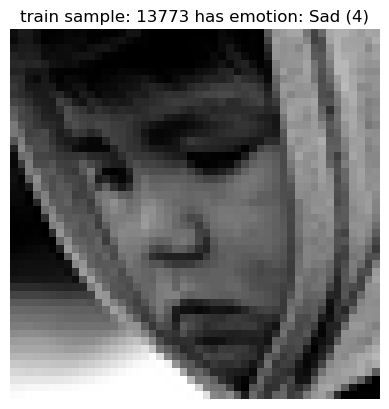

In [16]:
train_sample_img = create_image_from_rmo_list(pixels)

plt.title(f"train sample: {train_id} has emotion: {class2emotion[emotion]} ({emotion})")
plt.axis(False)
plt.imshow(train_sample_img, cmap='gray')
plt.show()

🦄 **Need to populate dataset with images for grid visualizations...**   
🦄 **Vision models exploit spatial features so need to feed in images anyways...**

In [18]:
%time
os.system('./utils/csv_to_imgs.py')

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 14.5 µs
Saving train images...


  1%|▏         | 95/7178 [00:00<00:07, 948.39it/s]

Saving test images...


100%|██████████| 7178/7178 [00:08<00:00, 880.77it/s]


0

🦄 **Also created a training annotations file!**

In [19]:
! ls dataset_FER/train/ | wc -l
! ls dataset_FER/test/ | wc -l

35887
7178


## Histograms, Counts & Global Data Statistics

In [42]:
def get_mean(img):
    return np.mean(img)


def get_std(img):
    return np.std(img)


def get_min(img):
    return np.min(img)


def get_max(img):
    return np.max(img)


def get_stats(img):
    return get_mean(img), get_std(img), get_min(img), get_max(img)

In [193]:
def plot_histogram(data, emotion_title, metric_title):
    sns.set_theme()
    plt.hist(data, bins=7)
    plt.title(f'{emotion_title} - Px {metric_title} Histogram')
    plt.xlabel(metric_title)
    plt.ylabel('Frequency')
    plt.show()

In [194]:
def get_stats_for_dataset(dataset_path, dataset_name="train"):
    print(f"Computing stats for {dataset_name} dataset...\n")
    mean_data, std_data, global_min, global_max = 0., 0., 0., 0.
    mean_per_emotion, std_per_emotion = {}, {}
    which_min, which_max = None, None
    count_samples = 0
    for dir_emote in os.listdir(dataset_path):
        for imfileName in os.listdir(dataset_path + dir_emote):
            img = cv2.imread(os.path.join(dataset_path, dir_emote, imfileName), cv2.IMREAD_GRAYSCALE)
            mean, std, min, max = get_stats(img)
            mean_data += mean
            std_data += std
            if min < global_min:
                global_min = min
                which_min = imfileName
            if max > global_max:
                global_max = max
                which_max = imfileName
            # print(imfileName, mean, std, min, max)
            count_samples += 1
            
            if dir_emote not in mean_per_emotion:
                mean_per_emotion[dir_emote] = []
                std_per_emotion[dir_emote] = []

            mean_per_emotion[dir_emote].append(mean)
            std_per_emotion[dir_emote].append(std)

        plot_histogram(mean_per_emotion[dir_emote], dir_emote, "Mean")
        plot_histogram(std_per_emotion[dir_emote], dir_emote, "Std")

        mean_per_emotion[dir_emote] = np.mean(mean_per_emotion[dir_emote])
        std_per_emotion[dir_emote] = np.mean(std_per_emotion[dir_emote])

    mean_data /= count_samples
    std_data /= count_samples

    print('Global Mean: ', mean_data)
    print('Global Std: ', std_data)
    print('Global min: ', global_min, ' in ', which_min)
    print('Global max: ', global_max, ' in ', which_max)
    
    # for k,v in mean_per_emotion.items():
    #     print(f"Img Mean for {k} emotion: {v}")

    # for k,v in std_per_emotion.items():
    #     print(f"Img Std for {k} emotion: {v}")


Computing stats for train dataset...



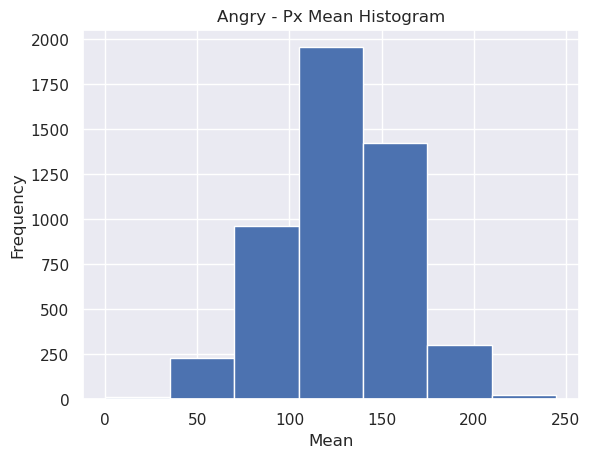

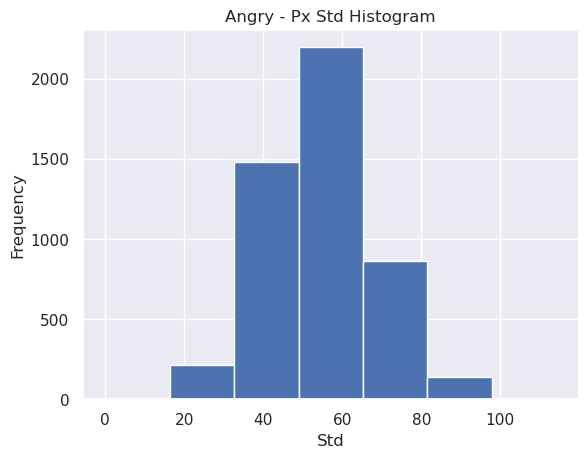

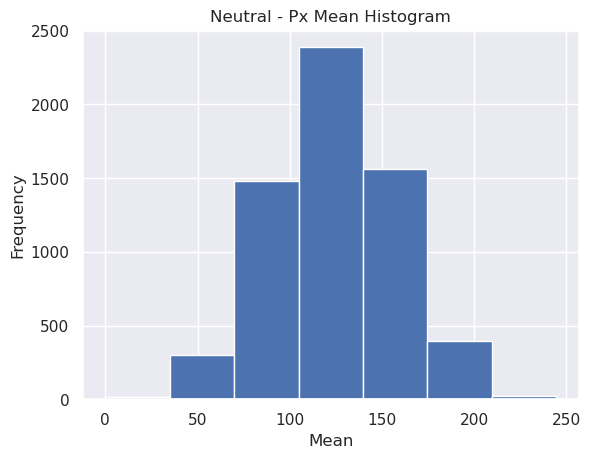

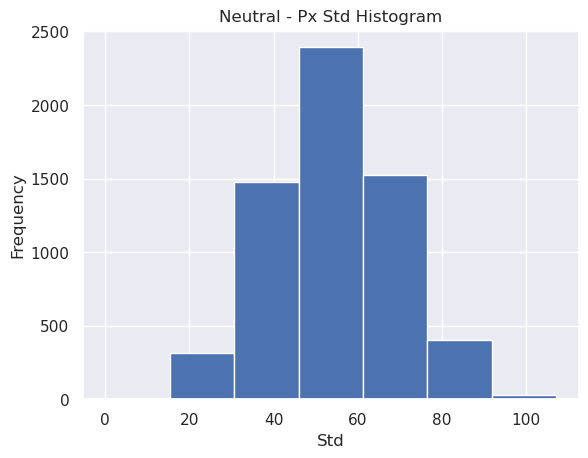

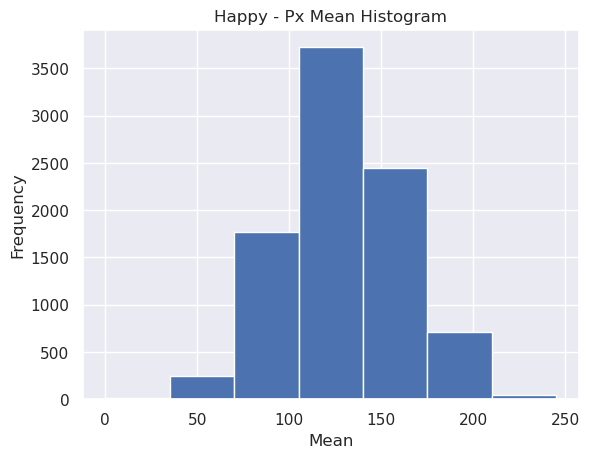

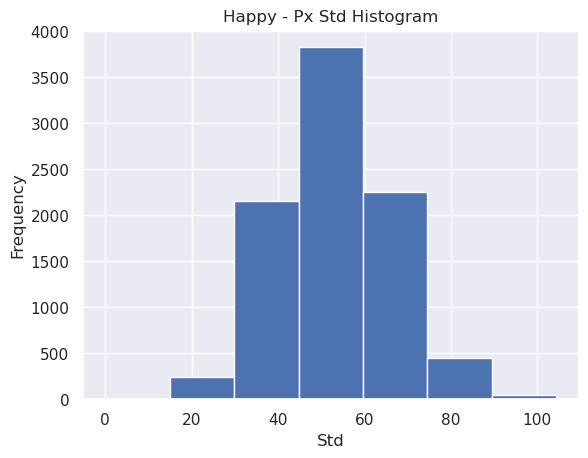

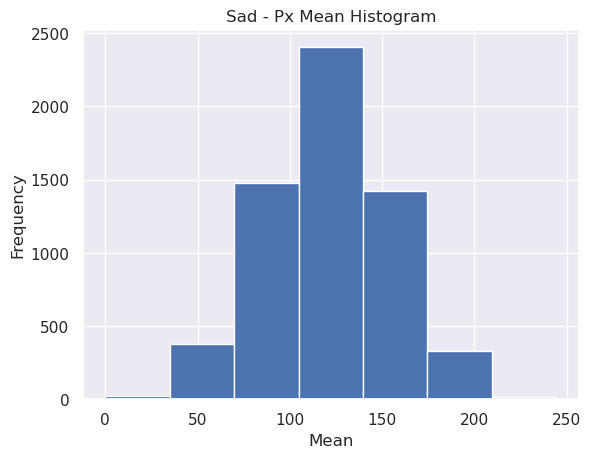

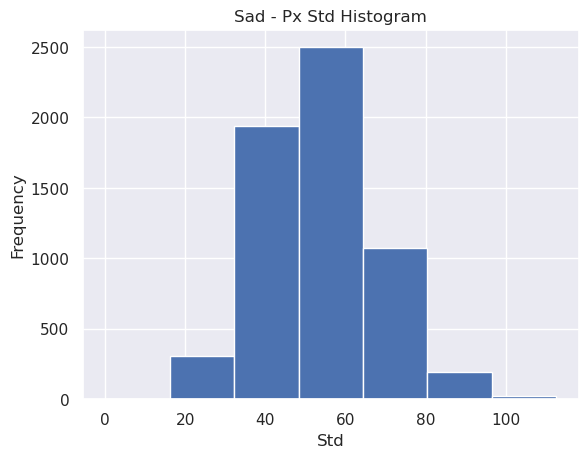

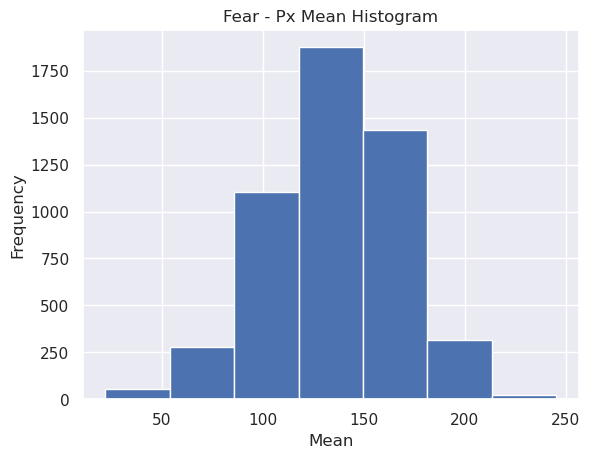

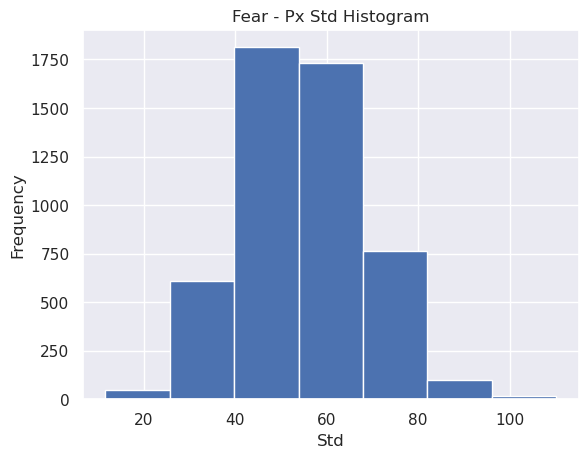

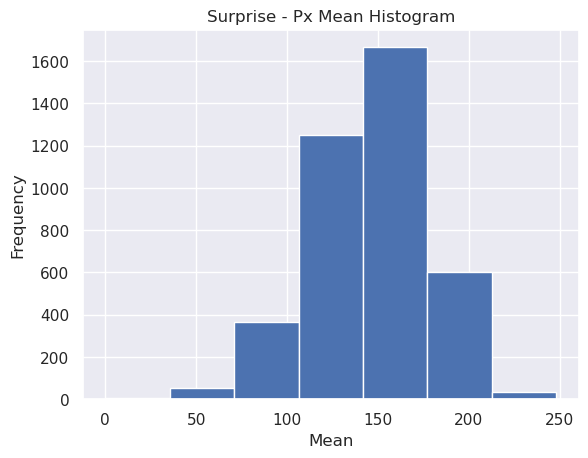

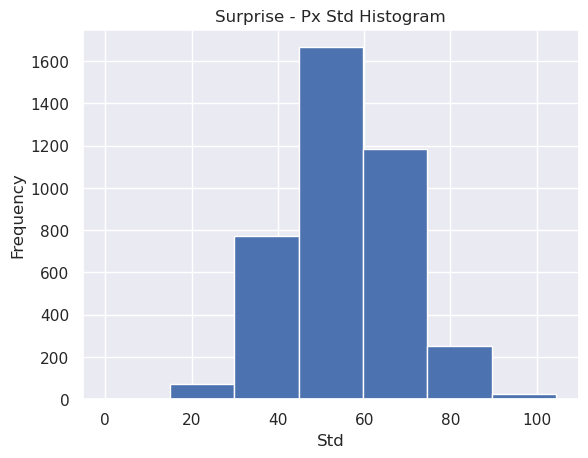

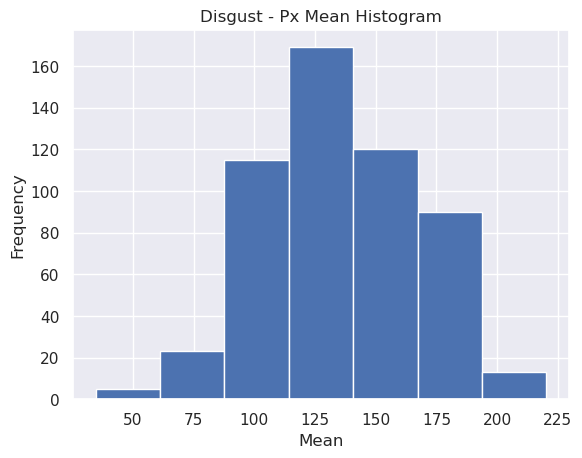

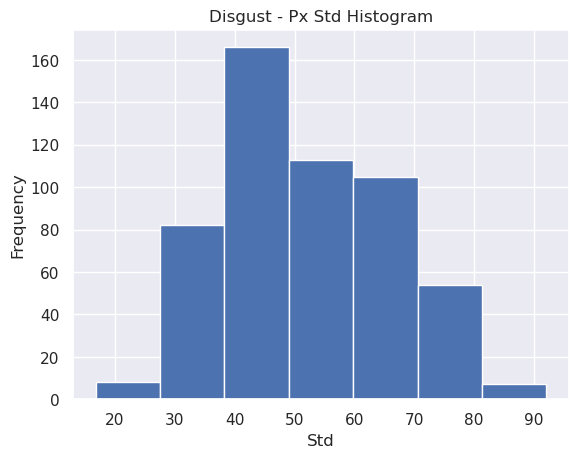

Global Mean:  129.40114694050467
Global Std:  54.06635166048223
Global min:  0.0  in  None
Global max:  255  in  Angry_3582.png
-------------------------------------------


In [195]:
get_stats_for_dataset('dataset_FER/train/', "train")
print("-------------------------------------------")

🦄  **Heavy data imbalance!**

## FastAI assisted EDA

In [109]:
train_files = get_image_files("dataset_FER/train")
test_files = get_image_files("dataset_FER/test")
len(train_files), len(test_files)

(35887, 7178)

In [110]:
dls = ImageDataLoaders.from_name_func(".", 
                                      train_files, 
                                      lambda fname: fname.split('_')[0], 
                                      item_tfms=Resize(224)) 

🦄 **Upsampling will introduce some artifacts (mostly blurring) but make the expression more prominent**

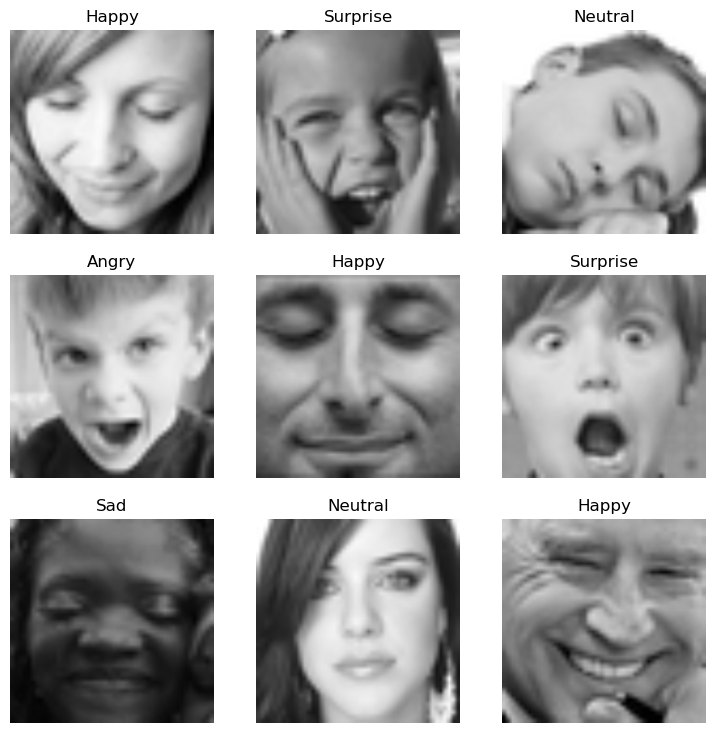

In [111]:
dls.show_batch()

### Finetuning on existing architectures for cleaning and setting a baseline benchmark 

Models to try: (see baselines.ipynb)   
1. Resnet-34 (used here as well)
2. Resnet50
3. Resnet101
4. VGG-16
5. VGG-19
6. visformer_small
7. vit_base_patch16_224
8. vit_base_r50_s16_224
9. swin_base_patch4_window7_224

In [112]:
learn = vision_learner(dls, "resnet34", metrics=error_rate)

SuggestedLRs(valley=0.0020892962347716093, slide=0.00363078061491251)

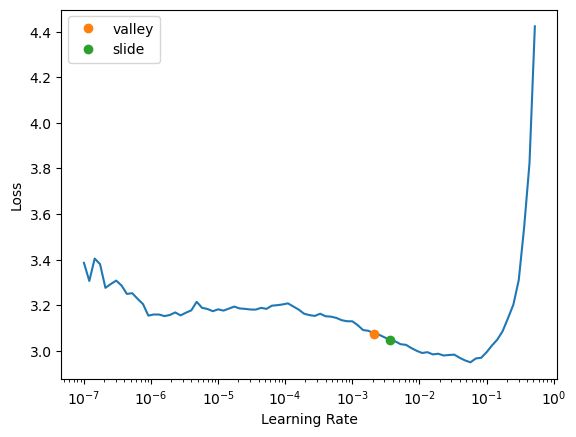

In [113]:
learn.lr_find(suggest_funcs=(valley, slide))

🦄 **100/(num_classes) == 14.28% would be the theoretical accuracy of a RNG**

🦄 **Generally can push LR a bit hihger for fine-tuning; suggestion is a bit conservative in my opinion**

In [117]:
# default freeze epochs = 1, unfreeze epochs = 6 (total = 7)
learn.fine_tune(6, 1e-2)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,1.330224,1.311542,0.498537,00:50
1,1.306622,1.262283,0.483071,00:50
2,1.206764,1.247139,0.476940,00:50
3,1.115003,1.148753,0.436812,00:50
4,1.007961,1.131014,0.425247,00:50
5,0.937214,1.134872,0.426780,00:50


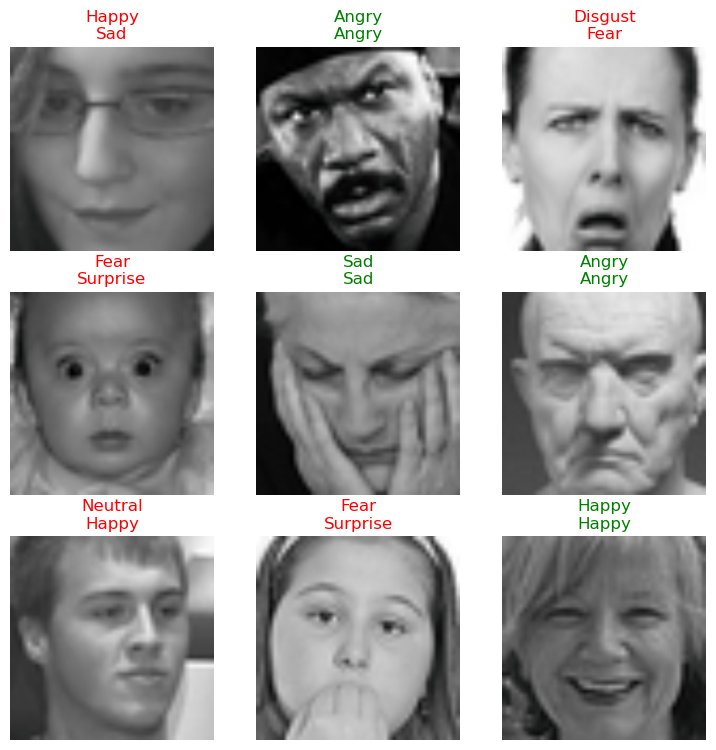

In [118]:
learn.show_results()

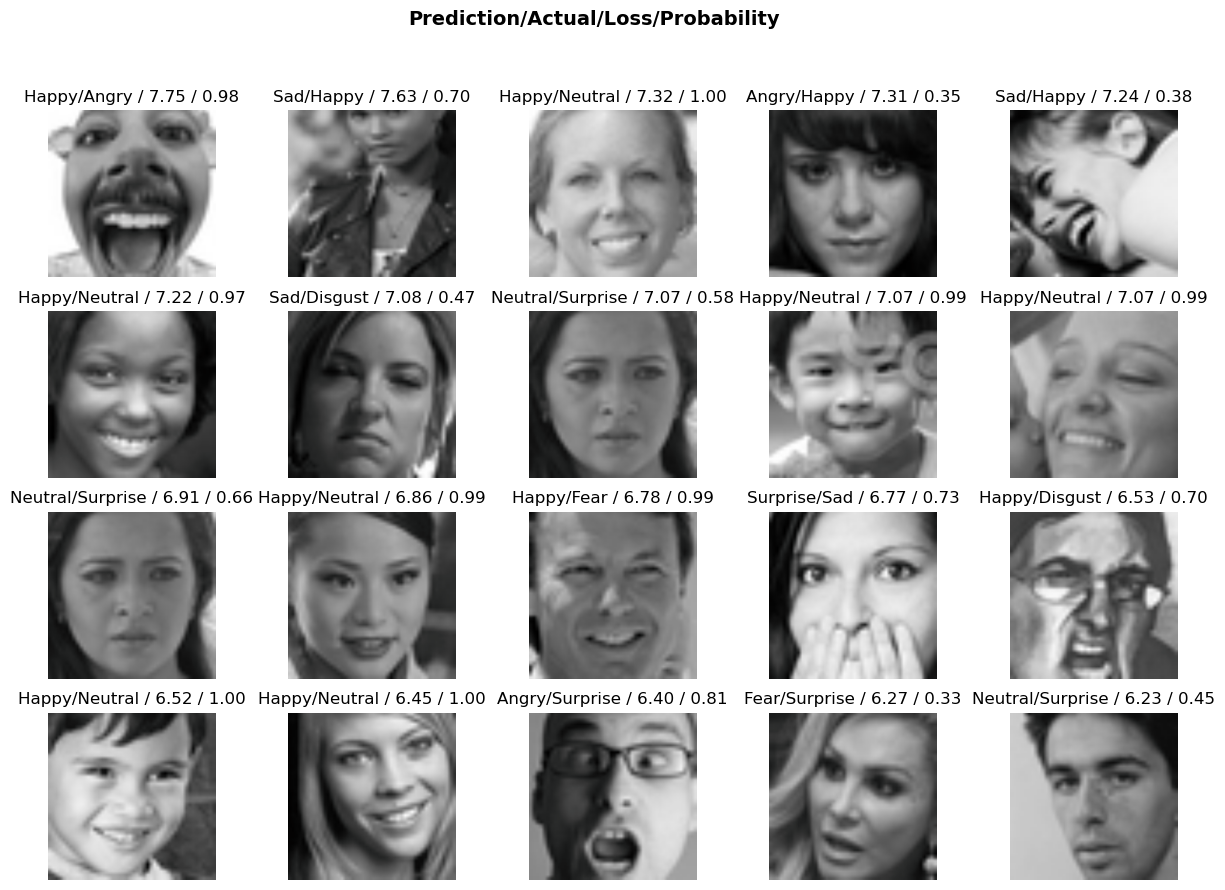

In [121]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(20, figsize=(15,10))

#### Confusion matrix to get an idea about the classes that are most close/correlated/difficult to segregate

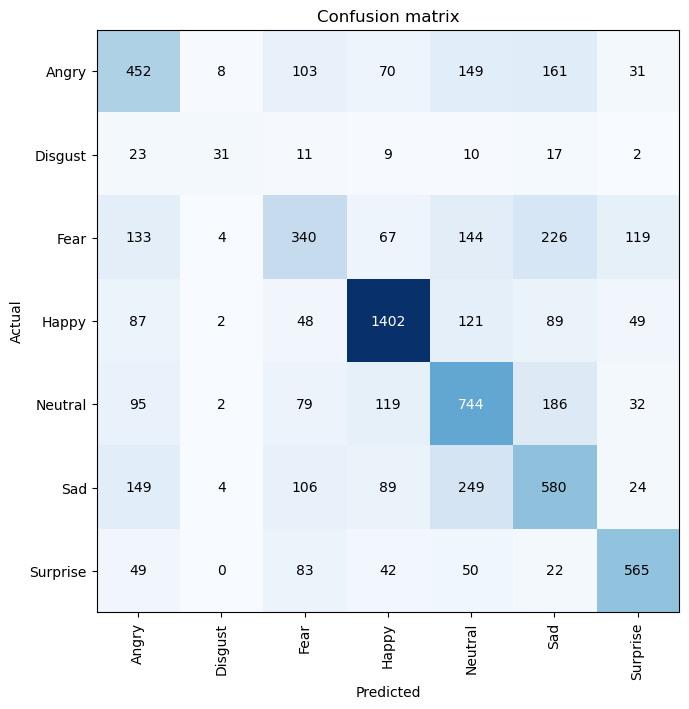

In [122]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

### 🤖 Qualitative Observations (for ResNet-34):

1. Get's confused between the following pairs:     
    a. Happy-Surprised   
    b. Surprise - Fear/Happy
    b. Neutral-Angry/Sad   

2. Fear and Sad are the most problematic classes for resnet34

3. The Predicted emotion looks closer to the actual emotion (to me!) for some of the top-losses above!

4. Need to clean dataset of images where there are multiple people in the shot

5. There are animated faces in the dataset as well!

In [126]:
cleaner = EnhancedImageClassifierCleaner(learn)
cleaner

In [129]:
# check if lists: cleaner.delete and cleaner.change have nothing
assert len(cleaner.delete()) == 0, "cleaner.delete() is not empty"
assert len(cleaner.change()) == 0, "cleaner.change() is not empty"


### ✂️ Cleaning observations:

0. There are duplicate images in the dataset as well --- deleted
1. There was an image of only text in disgust train dir --- deleted
2. There are a lot of mis-labelings --- deleted
3. Dataset is scraped from shutterstock as well
4. There are celebrities in the dataset including Farah Khan(She's an Indian Actress/Choreographer!), Barack Obama, Oprah Winfrey, iconic memes and a lot of baby photos alongside anime-like headshots (most of them are gory hence removed).
5. Fear train has many mislabels (deleted most since they could fall easily under neutral, surprised and/or sad)
6. Neutral was the most mislabeled and most were moved to happy
7. Neutral's validation set has a corrupted image --- deleted
8. Sad - train has a disturbing image where an animated character is crying with blood tears (deleted)
9. Sad - train has a magazine cover image as well (deleted)
10. There are images that are NOT natural. They are edited/perturbed and sometimes are objects are added in front of people's faces

In [140]:
if len_train_df != len(os.listdir('dataset_FER/train/')):
    print("[+] Great! The changes took place in train dir")
    # count all samples in train dir
    len_new = len(glob.glob('dataset_FER/train/*/*'))
    print(f"Samples deleted: {len_train_df - len_new} ({(len_train_df - len_new) / len_train_df * 100.:.2f}%)")

assert len_test_df == len(os.listdir('dataset_FER/test/')), "[-] WTF! Why would you delete the test images when they have no labels to start with?"

[+] Great! The changes took place in train dir
Samples deleted: 245 (0.68%)


### For verification that our cleaning was good (we should run the same model again with all params exactly the same)

In [143]:
dls = ImageDataLoaders.from_name_func("dataset_FER/", 
                                      get_image_files('dataset_FER/train'), 
                                      lambda x: x.split("_")[0], 
                                      item_tfms=Resize(224))

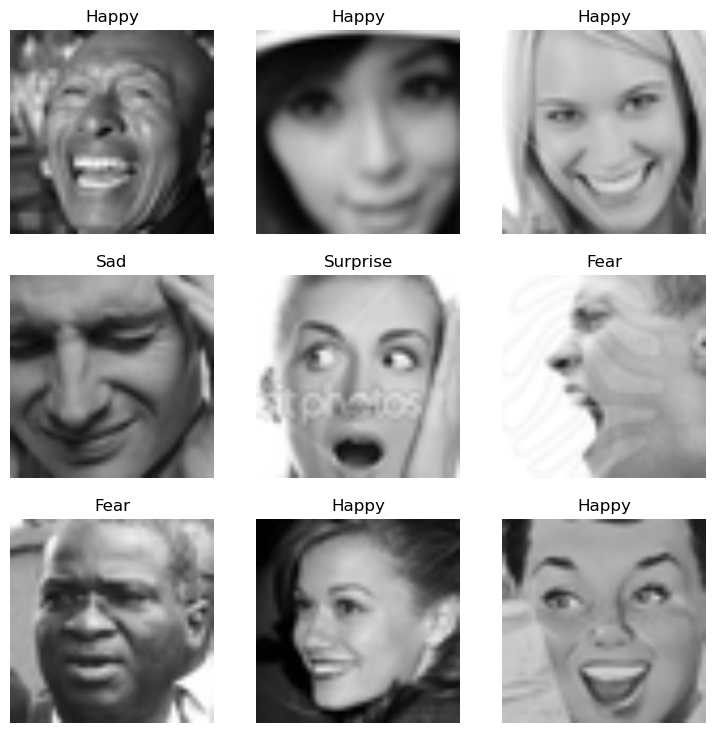

In [144]:
dls.show_batch()

In [146]:
learn2 = vision_learner(dls, "resnet34", metrics=error_rate)

In [147]:
learn2.fine_tune(6, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.513008,1.485098,0.576178,00:48
1,1.444047,1.348669,0.514450,00:48
2,1.285963,1.254807,0.487654,00:49
3,1.164221,1.178196,0.454265,00:49
4,1.054735,1.152340,0.437570,00:49
5,0.998019,1.151302,0.436027,00:49


# Acc remained the same and our train/inference time went down ==> Cleaning was successful!   
> Still need to clean more to see accuracy improvements